In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import scipy.ndimage
import multiprocessing
from multiprocessing import Pool
import struct
import random
import math

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import optimize as opt
import scipy
from scipy.io import loadmat  
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Forked from 'https://gist.github.com/akesling/5358964' -> GPL2
def read(path):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image. 
    """

    fname_img = os.path.join(path, 'training_set_images')
    fname_lbl = os.path.join(path, 'training_set_labels')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

allData = []
for i in read('data/'):
    allData +=  [ (i[1], i[0])]

In [5]:
sampleCount = 500
data = pd.DataFrame( allData[0:sampleCount], columns=['Image','Label'] )
data.head()

,Image,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9


In [6]:
(width, height) = data[0:1]['Image'][0].shape

In [7]:
temp = pd.DataFrame()
zoom = 1
for i in range(sampleCount): 
    curr = data['Image'][i] / 255.
    curr = scipy.ndimage.zoom(curr, zoom=zoom)
    (width, height) = curr.shape
    temp = temp.append( pd.DataFrame(curr.reshape((1, width*height))) )

temp.insert(0, 'Ones', 1.)
temp.head()

temp = temp.astype(float)
# sample = allData[ 7 ][0]
# sample = scipy.ndimage.zoom(sample, zoom=zoom)
# plt.imshow(sample)

In [8]:
x = temp
y = data['Label']

# Visualizing the Data

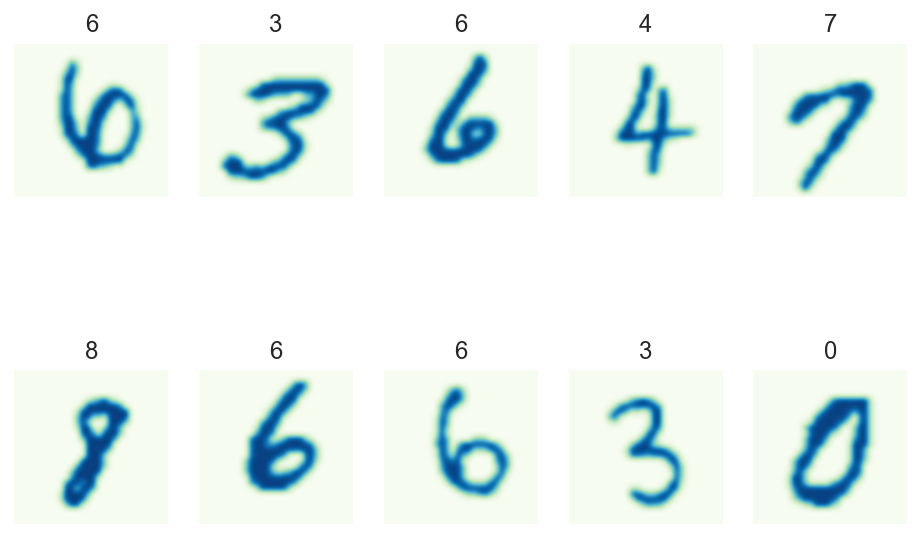

In [9]:
(row, col) = (2, 5)

fig, axes = plt.subplots(nrows=row, ncols=col)
plt.figure(figsize=(16,9))

for i in range(row):
    for j in range(col):
        currGen = allData[ random.randint(0, len(data)-1) ]
        axes[i][j].imshow(currGen[0], cmap=mpl.cm.GnBu, interpolation="bicubic")
        axes[i][j].set_title( str(currGen[1]) )
        
        axes[i][j].xaxis.label.set_visible(False)
        axes[i][j].axes.get_xaxis().set_visible(False)
        axes[i][j].axes.get_yaxis().set_visible(False)

# Logistic Regression
### sigmoid function
$f(x)=\frac{1}{1+e^{-x}}$

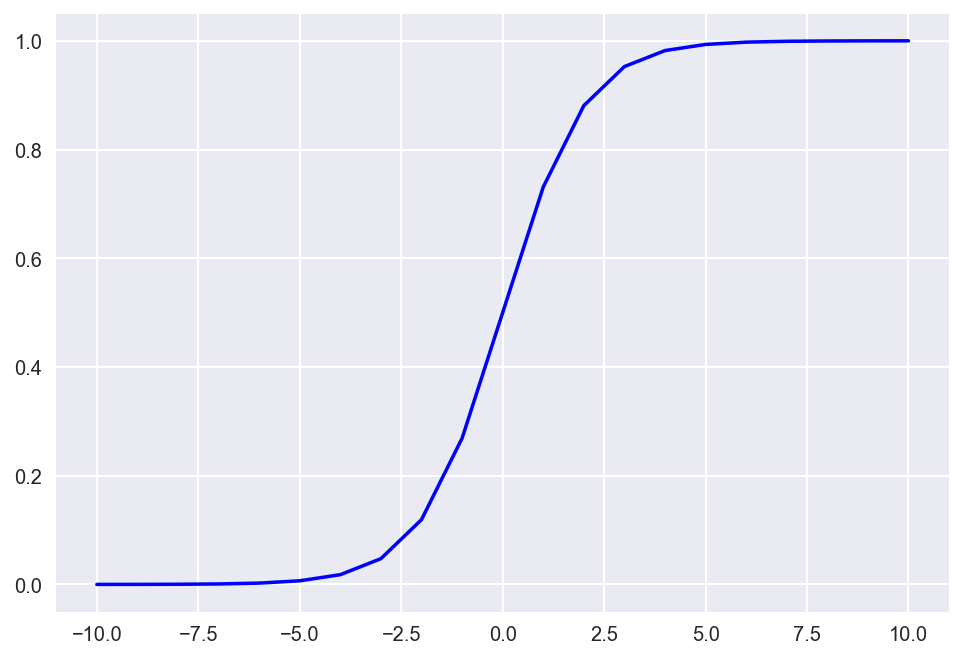

In [10]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

tempX = np.array(range(-10,11))
tempY = list( map(sigmoid, tempX) )
plt.plot(tempX, tempY, 'b')

In [11]:
def cost(theta, X, y, landa):
    m = NUM_OF_DATA
    first = np.multiply(-y, np.log(sigmoid(np.dot(X , theta.T))))
    second = np.multiply((1 - y), np.log(1 - sigmoid(np.dot(X , theta.T))))
    reg = (landa / 2 * len(X)) * np.sum(np.power(theta, 2))
    return np.sum(first - second) / (len(X)) + reg

In [12]:
def gradient(theta, X, y, landa):  
    X = np.array(X)
    parameters = len(X[0])

    grad = np.zeros(parameters)
    error = sigmoid(np.dot(X,theta.T)) - y
    m = NUM_OF_DATA
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        if (i == 0):
            grad[i] = np.sum(term) / m
        else:
            grad[i] = (np.sum(term) / m) + ((landa / m) * theta[i])
    return grad

In [13]:
alpha = 0.8
max_it = 500
landa = 0.000001
theta_vals = []
NUM_OF_DATA = 100

In [14]:
def classification( args ):
    (x, y) = args
    m = x.shape[0]
    n = x.shape[1]
    theta = np.zeros(n)
    count_it = 0
    J = []
    while count_it < max_it :
        count_it += 1
        if count_it % 100 == 0:
            print(count_it)
        npd = np.dot(x , theta)
        npde = np.exp(-npd)
        h = 1./(1 + npde)
        j = cost(theta,x,y,landa)
        g = gradient(theta,x,y,landa)
        theta = theta - alpha * g
        J.append(j)
    return theta

In [15]:
def one_vs_all_classification(img, y, k):
    for i in range(0,k):
        print("------",i)
        y = create_lable(i,y)
        theta = classification( (img , y) )
        theta_vals.append(theta)
        
one_vs_all_classification(x, y, 10)

------ 0


NameError: name 'create_lable' is not defined

In [18]:
def workerFunc( args ):
    x, y, landa, label = args
    x0 = np.zeros( (x.shape[1],1) )
    print(label, "starting!")
    res = opt.minimize(cost, x0,jac=gradient, method='TNC', options={'disp': True}, args=(x, [ 1 if yy == label else 0 for yy in y], landa))
    print(label, "compelete!")
    return res.x
    return num
    
def findAllThatas(x, y, labels, landa=0.000001):
    p = Pool( len(labels) )
    return p.map(classification, [ (x, create_lable(label, y)) for label in labels ])

thetas = findAllThatas(x, y, [1,2,3,4,5,6,7,8,9])

100
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300
300
400
400
400
400
400
400
400
400
400
500
500
500
500
500
500
500
500
500


In [19]:
def create_lable(lable_val , lables):
    return np.array([int (x==lable_val) for x in lables])

In [20]:
def passProbability(theta, image):
    return sigmoid(np.dot(theta, np.array(image).T))

In [21]:
PP = 0
for j in range(100):

    resP = 0
    resX = None
    for i in [(zzz, passProbability( thetas[zzz], x.iloc[j])) for zzz in range(10)]:
        if i[1] > resP:
            resP = i[1]
            resX = i[0]
#     print( x.iloc[j] )
#     0
#     print( np.array([(zzz, passProbability( thetas[zzz], x.iloc[j])) for zzz in range(10)]) )
    
    if y[j] == resX:
        PP += 1
        
print( PP )

IndexError: list index out of range

In [22]:
theta = np.array(theta_vals)
theta.shape

(0,)

In [23]:
with open("data/training_set_labels", 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    lbl_test = np.fromfile(flbl, dtype=np.int8)

with open("data/training_set_images", 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img_test_view = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl_test),rows,cols)
    img_test = img_test_view.reshape(len(lbl_test),rows*cols)

img_test = img_test/255.
img_test = np.concatenate((np.ones((1,len(lbl_test))), img_test.T)).T

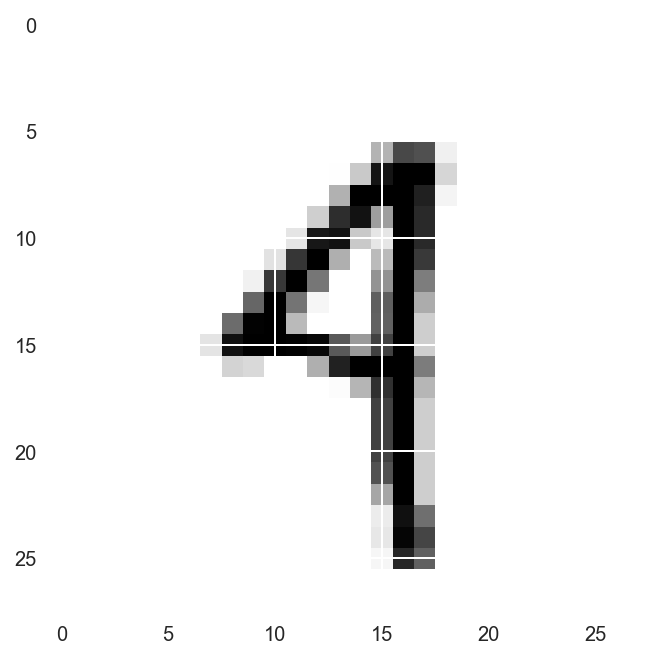

ValueError: shapes (0,) and (785,) not aligned: 0 (dim 0) != 785 (dim 0)

In [24]:
idx_test = random.randint(0,len(lbl_test))
plt.imshow(img_test_view[idx_test], cmap='gray_r')
plt.show()

immm = scipy.ndimage.zoom(img_test[idx_test], zoom=zoom)
ans = sigmoid(np.dot(theta,immm.T))
for i in range(0,10):
    print ("predicted probability for value ",i," is: ",ans[i])
print ("---")
print ("predicted value is: " , ans.argmax())
print ("real value is: ",lbl_test[idx_test])